<a href="https://colab.research.google.com/github/soniajoseph/ViT-Prisma/blob/main/demos/Emoji_Logit_Lens_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Emoji Logit Lens

by Sonia Joseph

Twitter [@soniajoseph_](https://twitter.com/soniajoseph_)

--

This notebook shows **patch-level logit lens predictions for a vanilla vision transformer (ViT)**.

The functions are part of the [Prisma repo](https://github.com/soniajoseph/ViT-Prisma/) for multimodal mechanistic interpretability.

### This notebook shows you how to use two interactive visualizations: ###

a) Emoji Logit Lens overlaid on the original image.

b) Emoji Logit Lens throughout all layers (i.e. see how the net's predictions evolve as the patches pass through the net).


<br>

**Static preview (scroll down for interactive visualization):**


<p float="center">
  <img src="https://github.com/soniajoseph/prisma-development/blob/main/prisma-development/emoji_logit_lens_notebook_assets/cat.png?raw=true" alt="Description of image 1" width="350" />

  <img src="https://github.com/soniajoseph/prisma-development/blob/main/prisma-development/emoji_logit_lens_notebook_assets/patch_logit_lens.png?raw=true" alt="Emoji logit lens through layers" width="500" />
</p>

<iframe src="https://raw.githubusercontent.com/soniajoseph/prisma-development/main/prisma-development/emoji_logit_lens_notebook_assets/patch_level_logit_lens.html" width="800" height="600"></iframe>




# More details about the logit lens (optional)



### Background on logit lens ###

The logit lens technique means feeding the output of each model layer into the model's classification head to yield a prediction for that layer. This is the equivalent to deleting all the subsequent layers between your chosen layer and the output head.

Thus, we can see how the neural net's "predictions" evolve as the image passes through the net.

The logit lens method originally from language to get predictions from the intermediate layers of GPT-2 (see original blogpost [here](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)).


--

### FAQ ###

**Q: Why are you using emojis?**

Well, they're fun 🐱. But seriously-- originally, I overlaid the ImageNet class name on the patch, but the font size was too small to be readable. Emojis are very practical here.

**Q: Can I tweak the visualization to suit my own purposes?**

Yes, absolutely. This notebook shows you how to make segmentation maps, adjust the transparency, and adjust emoji size. You're also welcome to fork the [original code](https://github.com/soniajoseph/ViT-Prisma/) to suit your purposes!

**Q: What is a patch?**

We divide our image into patches, which are analogous to tokens in language models.

**Q: How do I learn more?**

For more on how vision transformers work, check out the other tutorials on the [Prisma repo](https://github.com/soniajoseph/ViT-Prisma/).

# Load functions (ignore)

In [1]:
# Install the Prisma repo library (update version number or clone from source for latest functionality)

!pip install vit_prisma==0.1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [2]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet_emoji import IMAGENET_EMOJI
from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT

import plotly.express as px
import plotly.graph_objects as go


from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

import jaxtyping

import numpy as np
import torch
from collections import defaultdict

In [3]:
# Helper functions (ignore)
class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),  # Convert images to tensor
])

# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

# Load the model

<details>
Load a vanilla vision transformer that takes in images 224x224 and divides them into non-overlapping patches of size 32. We'll be using Prisma's HookedViT functionality to cache intermediate activations, originally based off TransformerLens.

This ViT was trained on ImageNet so we'll be doing 1000-way classification on the patches.
</details>

In [4]:
# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
model = HookedViT.from_pretrained("vit_base_patch32_224",
                                        center_writing_weights=True,
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


# Load your data

We'll load a bunch of images we'll use throughout the notebook.

You're encouraged to swap out with your images after going through this tutorial!

In [5]:
!wget https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/toilet_cat.jpeg?raw=true -O toilet_cat.jpg > /dev/null 2>&1
!wget https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/fruit_bowl.jpeg?raw=true -O fruit.jpg > /dev/null 2>&1
!wget https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/child_lion.jpeg?raw=true -O child_lion.jpg > /dev/null 2>&1
!wget https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/cheetah.jpeg?raw=true -O cheetah.jpg > /dev/null 2>&1


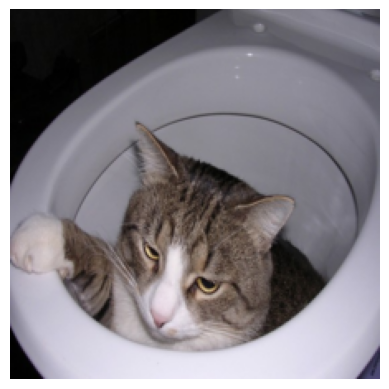

In [6]:
image = Image.open('toilet_cat.jpg')
image = transform(image)
plot_image(image)

We're collect the per-patch logit direction for every layer of the net.

This is the equivalent to feeding the output of every layer directly into the classification head to get the predictions for that layer (i.e. deleting all subsequent layer between that layer and the classification head).

In [7]:
from vit_prisma.prisma_tools.logit_lens import get_patch_logit_directions, get_patch_logit_dictionary

output, cache = model.run_with_cache(image.unsqueeze(0))
all_answers = model.tokens_to_residual_directions(np.arange(1000)) # 1000 different ImageNet classes
patch_logit_directions, labels = get_patch_logit_directions(cache, all_answers)
print("Size of patch logit directions:", patch_logit_directions.shape) # batch x patch number x layer number x logit number
patch_logit_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0) # Function to turn the above into a dictionary

Size of patch logit directions: torch.Size([1, 50, 13, 1000])


Let's overlay the per-patch logit predictions over the original image. Hover over the interactive plot below to see the class prediction and logit value for each patch. We can see that the ViT acts as a segmentation map without explicitly being optimized to do so!

<details>

Higher logit predictions mean that the class was more probable (see the colorbar on the right). The emoji is the predicted class.

We can see that the ViT picks up on the cat the most strongly. The per-patch logit lens acts as a segmentation map, with predictions having spatial localization. The toilet patches are predicted as toilet, and the cat patches are predicted as cat! Before this visualization, the spatial localization of vision transformers was not totally obvious, as the ViT is only being optimized to predict the CLS token!

It's not totally clear where "Irish terrier" came from, although the net does not weight this patch highly.
</details>

In [8]:
from vit_prisma.visualization.patch_level_logit_lens import display_grid_on_image_with_heatmap

fig = display_grid_on_image_with_heatmap(image, patch_logit_dictionary, emoji_font_size=35, return_graph=True, alpha_color=.4)
fig.show()


Above are the per-patch predictions for the final layer. But how do the predictions evolve through the net?

Let's grab our logit dictionary and plot the per-patch logit prediction per layer. Hover over the interactive plot to read the class prediction and logit value per patch!

The net seems to only pick up on the cat/toilet after the 9th layer / beginning of 10th! Before that, the net's predictions seem decently random.

<details>
n_pre means the residual stream at the start of layer n.

</details>

In [9]:
from vit_prisma.visualization.patch_level_logit_lens import display_patch_logit_lens
fig = display_patch_logit_lens(patch_logit_dictionary, labels=labels, return_graph=True)



Let's visualize the per-layer per-patche predictions in more detail. This is the same visualization as above, except the patches are overlaid on the image.

Fascinatingly, before layer 9, the net seems to be classifying the cat as some kind of dog!

<details>

Change the parameter `layer_idx` to pick which layer gets visualized. By default, this is set to `-1` for the last layer.

</details>

In [10]:
for layer_idx, label_name in enumerate(labels):
  fig = display_grid_on_image_with_heatmap(image, patch_logit_dictionary, return_graph=True,layer_idx = layer_idx) # Iterate through all 12 layers
  fig.update_layout(width=600, height=600, title=f"{label_name}")  # Adjust width and height as needed
  fig.show()


Let's tweak the original visualization to color the patches based on the same emoji, instead of logit value. With this coloration, the segmentation map between cat/toilet becomes more obvious!

Change the parameter `heatmap_mode` to `'emoji_colors'`.

<details>

We can also play with `emoji_font_size` to make the emojis a little bigger for fun.

</details>.

In [11]:
fig = display_grid_on_image_with_heatmap(image, patch_logit_dictionary, heatmap_mode='emoji_colors', alpha_color=.4, emoji_font_size=40, return_graph=True)
fig.show()

That's it! Let's try the same process on more images...

# More images

Below we have this somewhat messy fruit bowl predictions.

In [12]:
image = Image.open('fruit.jpg')
image = transform(image)
output, cache = model.run_with_cache(image.unsqueeze(0))
all_answers = model.tokens_to_residual_directions(np.arange(1000))
patch_logit_directions, labels = get_patch_logit_directions(cache, all_answers)
patch_logit_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label='toilet')

fig = display_grid_on_image_with_heatmap(image, patch_logit_dictionary, emoji_font_size=30, return_graph=True, alpha_color=.4, layer_idx=-1)
fig.show()

Interestingly, its predictions seem slightly more accurate on the second-to-last layer than the last layer. It's as if the last layer made things worse! Here, at least the net classifies some of the grape patches as wine or figs instead of strawberries.

In [13]:
fig = display_grid_on_image_with_heatmap(image, patch_logit_dictionary, emoji_font_size=30, return_graph=True, alpha_color=.4, layer_idx=-2)
fig.show()

The net seems to be classifying the grapes as pingpong balls if we go one more layer back from that!

In [14]:
fig = display_grid_on_image_with_heatmap(image, patch_logit_dictionary, emoji_font_size=30, return_graph=True, alpha_color=.4, layer_idx=-3)
fig.show()

Ok, let's try a new image.

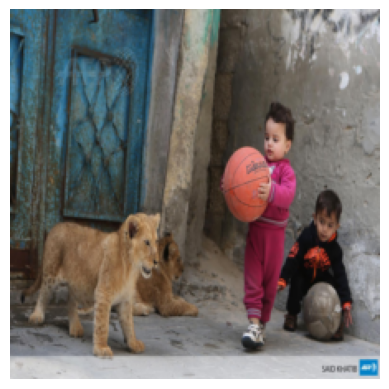

In [15]:
image = Image.open('child_lion.jpg')
image = transform(image)
plot_image(image)

In [16]:
output, cache = model.run_with_cache(image.unsqueeze(0))
all_answers = model.tokens_to_residual_directions(np.arange(1000))
patch_logit_directions, labels = get_patch_logit_directions(cache, all_answers)
patch_logit_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label='fruit')
display_grid_on_image_with_heatmap(image, patch_logit_dictionary)

The net does a decent job getting the lion and the basketball. It's not totally clear why there are lion patches at the edge of the image.

There is also some ethnic bias here as the net is classifying the children as "abaya," which is a gown-- perhaps due to the children's ethnicity. The net is restricted to 1000 ImageNet classes and these patches likely had the closest similarity to abaya.

It's an important lesson that the "limits of the vision transformer's dictionary are the limits of its world" and can lead to bias problems if its dictionary is not expressive enough.


**Let's try one more image**

Here, the model aggressively predicts gazelle/impala!

In [17]:
image = Image.open('cheetah.jpg')
image = transform(image)
output, cache = model.run_with_cache(image.unsqueeze(0))
all_answers = model.tokens_to_residual_directions(np.arange(1000))
patch_logit_directions, labels = get_patch_logit_directions(cache, all_answers)
patch_logit_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label='fruit')
display_grid_on_image_with_heatmap(image, patch_logit_dictionary, heatmap_mode='emoji_colors')

Similar to what we saw before, patch-level predictions become more accurate when we go one layer back, with more real estate being given to the cheetah. Perhaps the patches predictions are trading off against each other at the final layer of the net?

In [18]:
display_grid_on_image_with_heatmap(image, patch_logit_dictionary, heatmap_mode='emoji_colors', alpha_color=.4, layer_idx=-2)

Here is the full logit lens for the cheetah/gazelle image.

In [19]:
from vit_prisma.visualization.patch_level_logit_lens import display_patch_logit_lens
fig = display_patch_logit_lens(patch_logit_dictionary, labels=labels, return_graph=True)
